In [25]:
import numpy as np
import pandas as pd
import os
import Resampled_learn as rsl
import xgboost as xgb

In [26]:
os.chdir("C:/Users/zhaow/Dropbox/Datascience/titanic")

In [27]:
df_train = pd.read_csv('titanic_train_resample.csv')
df_test = pd.read_csv('titanic_test_resample.csv')

In [11]:
"""訓練用、テスト用データの生成"""
X_train = df_train.drop('PassengerId', axis = 1)
X_train = X_train.drop('Survived', axis = 1)
Y_train = df_train['Survived']
X_test = df_test.drop('PassengerId', axis = 1)
PassangerId = df_test['PassengerId']

In [12]:
print('Survived: %d ' % Y_train.sum())
print('Died: %d' % (len(Y_train) - Y_train.sum()))

Survived: 342 
Died: 549


生きている人より死んでいる人のほうが多い不均衡データ

In [28]:
"""アンダーサンプリング（少ないデータに多い方のデータを落とす）で不均衡を解消してクロスバリデーション"""
rfe = rsl.Resampled_Cross_Validate(n_splits=10, verbose=True, estimator=xgb.XGBClassifier(n_jobs=-1),
                                   sampler=rsl.RandomUnderSampler(ratio='not minority'))

In [29]:
rfe.fit(X_train, Y_train)

Start Processing Resampled Validation: 10 splits
Done: 1, Totaling: 10
Done: 2, Totaling: 10
Done: 3, Totaling: 10
Done: 4, Totaling: 10
Done: 5, Totaling: 10
Done: 6, Totaling: 10
Done: 7, Totaling: 10
Done: 8, Totaling: 10
Done: 9, Totaling: 10
Done: 10, Totaling: 10


In [32]:
print('Accuracy: %.3f' % rfe.acc_.mean())
print('Precision Score: %.3f' % rfe.pre_.mean())
print('Recall Score: %.3f' % rfe.rec_.mean())
print('F1 Score: %.3f' % rfe.f1_.mean())
print('ROC AUC: %.3f' % rfe.roc_auc_.mean())
print('log loss: %.3f' % rfe.logloss_.mean())

Accuracy: 0.816
Precision Score: 0.747
Recall Score: 0.792
F1 Score: 0.766
ROC AUC: 0.812
log loss: 0.423


In [33]:
smt = rsl.RandomUnderSampler(ratio='not minority')

In [34]:
"""不均衡性を解消し、再帰的特徴量削減によって特徴量削減"""
rfecv = rsl.Resampled_RFECV(cv=10, n_steps=1,
                            estimator=xgb.XGBClassifier(),
                            sampler=smt)

In [35]:
rfecv.fit(X_train, Y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.35it/s]


<Figure size 432x288 with 0 Axes>

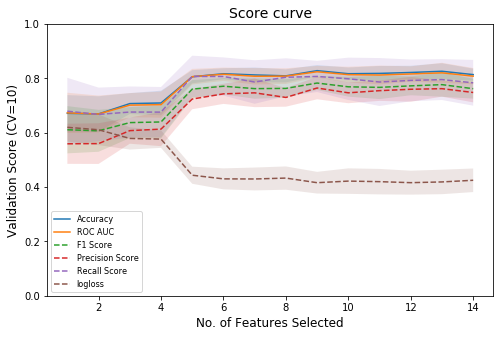

In [36]:
rfecv.draw_figure(X_train, Y_train, ymin=0.0, ymax=1.0, fill_btw=True)

<Figure size 432x288 with 0 Axes>

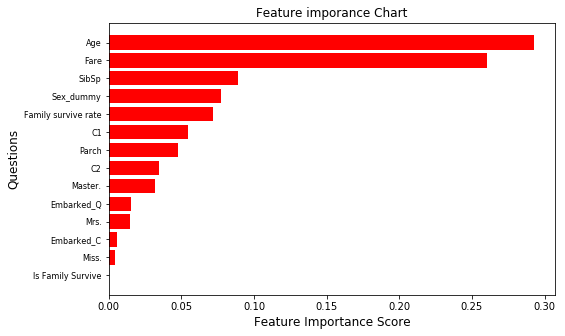

In [37]:
rfecv.draw_barchart(X_train, Y_train)